# Graph Centrality

_And so we all matter - maybe less then a lot but always more than none_ - John Green 

Concepts:
- BEA Input-Output Use Table
- Centrality

References:
- Jason Choi & Andrew T. Foerster, 2017. "The Changing Input-Output Network Structure of the U.S. Economy," Economic Review, Federal Reserve Bank of Kansas City, issue Q II, pages 23-49
- https://www.bea.gov/industry/input-output-accounts-data
- https://www.bea.gov/information-updates-national-economic-accounts


In [1]:
import pandas as pd
from pandas import DataFrame, Series
import networkx as nx
from finds.database import RedisDB
from finds.readers import BEA
from finds.recipes import graph_info, graph_draw
from secret import credentials
# %matplotlib qt
VERBOSE = 0
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 200)

In [2]:
rdb = RedisDB(**credentials['redis'])
bea = BEA(rdb, **credentials['bea'], verbose=VERBOSE)
years = [1947, 2022]
vintages = [1997, 1963, 1947]   # when sectoring schemes were revised
vintage = min(vintages)

## Centrality measures

Measures of graph centrality quantify the importance of nodes
within a graph.

- __Degree Centrality__ measures the number of edges connected to a node.

- __Betweenness Centrality__ quantifies the extent to which a node lies
  on the shortest paths between other nodes in the graph.

- __Closeness Centrality__ measures how close a node is to all other
  nodes in the graph in terms of shortest path lengths.

- __Eigenvector Centrality__ evaluates the centrality of a node based
  on the centrality of its neighbors, Nodes with higher eigenvector
  centrality are connected to other highly central nodes.

- __PageRank Centrality__ was originally developed for ranking web
  pages by importance.  It can be viewed as a random walk
  process on the graph, representing the long-term likelihood of
  visitation of each node by randomly following edges.

- A __Hub__ is a node that has many out-edge to other nodes. It acts as as a facilitator of flows other parts of the graph

- An __Authority__ is a node that has many in-edges from other nodes.  It can be regarded as highly influential in that many other nodes reference it.

In [3]:
# Helper to compute centrality measures
def nodes_centrality(G, weight='weight', cost=False, alpha=0.99):
    """Return dict of vertex centrality measures                                     
                                                                                     
    Args:                                                                            
        G: Graph may be directed or indirected, weighted or unweighted               
        weight: name of edge attribute for weights, Set to None for unweighted       
        cost: If True, then weights are costs; else weights are importances          
    """
    out = {}
    # Degree centrality, for directed and undirected graphs
    if nx.is_directed(G):
        out['in_degree'] = nx.in_degree_centrality(G)
        out['out_degree'] = nx.out_degree_centrality(G)
    else:
        out['degree'] = nx.degree_centrality(G)

    # Hubs and Authorities
    out['hub'], out['authority'] = nx.hits(G)

    # if weights are costs, then Eigenvector and Pagerank ignore weights 
    if not cost and nx.is_weighted(G):
        out['eigenvector'] = nx.eigenvector_centrality(G, weight=weight, max_iter=1000)
        out['pagerank'] = nx.pagerank(G, weight=weight, alpha=alpha)
    else:
        out['eigenvector'] = nx.eigenvector_centrality(G, max_iter=1000)
        out['pagerank'] = nx.pagerank(G, alpha=alpha)

    # if weights are importances, then Betweeness and Closeness ignore weights 
    if cost and nx.is_weighted(G):
        out['betweenness'] = nx.betweenness_centrality(G, weight=weight)
        out['closeness'] = nx.closeness_centrality(G, distance=weight)
    else:
        out['betweenness'] = nx.betweenness_centrality(G)
        out['closeness'] = nx.closeness_centrality(G)
    return out


## BEA Input-Output Use Tables

Input-output analysis is a type of economic model used to study
the interdependencies between different sectors of an economy. It
typically involves constructing an input-output table that records the
flows of goods and services between sectors. This
quantifies the relationships between inputs and outputs among various
sectors, showing how changes in one sector can affect others. 

In [4]:
# Read IOUse tables from BEA website
ioUses = {year: bea.read_ioUse(year=year, vintage=vintage) for year in years}

In [5]:
## Set directed edges with tail on user (table column) --> head on maker (row)
## Direction of edges point from user industry to maker, i.e. follows the money
tail = 'colcode'   # edges follow flow of payments, from column to row
head = 'rowcode'   
drop = ('F','T','U','V','Other')  # drop these codes
colors = ['lightgrey', 'darkgreen', 'lightgreen']    

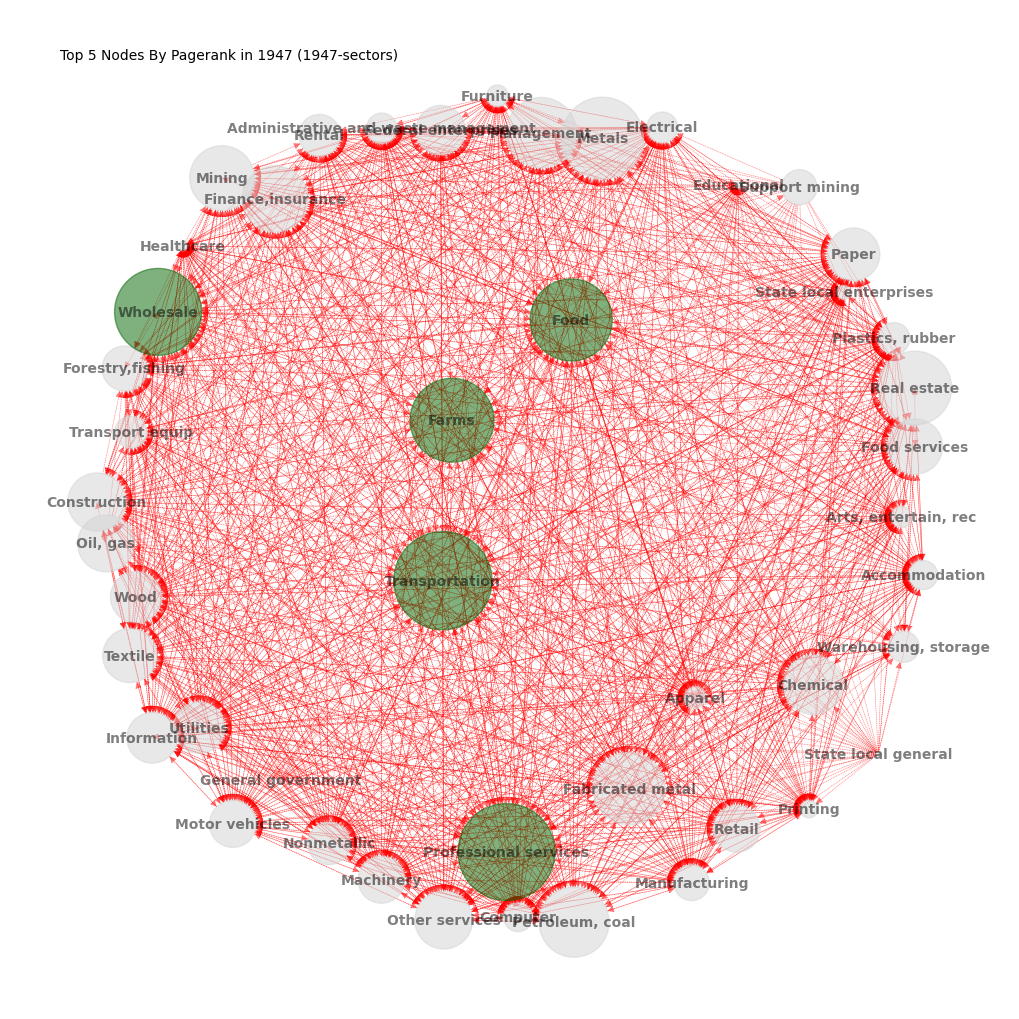

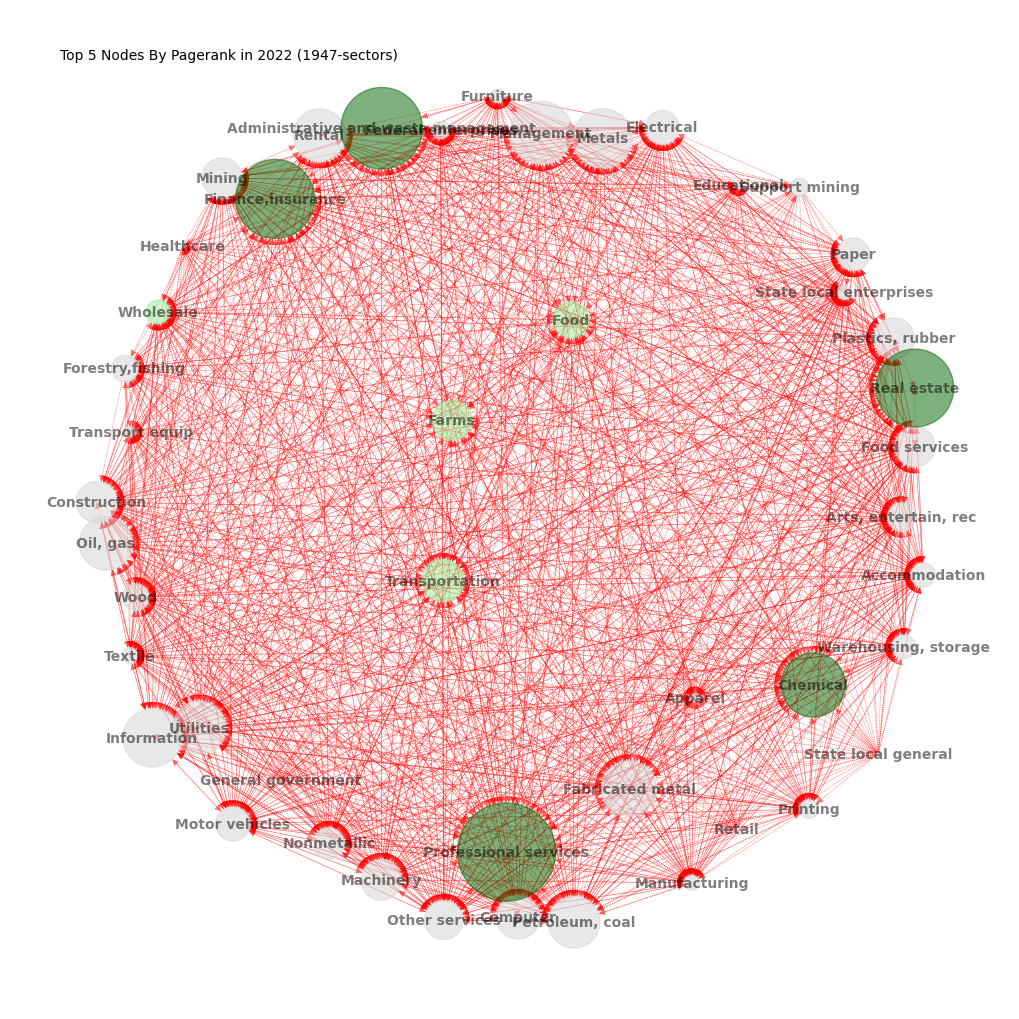

In [13]:
# Populate and plot graph of first and last table years
for ifig, year in enumerate(years):
    # keep year, drop invalid rows
    ioUse = ioUses[year]
    data = ioUse[(~ioUse['rowcode'].str.startswith(drop) &
                  ~ioUse['colcode'].str.startswith(drop))].copy()

    # create master table of industries and measurements
    master = data[data['rowcode'] == data['colcode']][['rowcode','datavalue']]\
        .set_index('rowcode')\
        .rename(columns={'datavalue': 'self'})
    
    # extract cross data; generate and load edges (as tuples) to graph
    data = data[(data['colcode'] != data['rowcode'])]
    data['weights'] = data['datavalue'] / data['datavalue'].sum()
    edges = data.loc[data['weights'] > 0, [tail, head, 'weights']]\
                .values\
                .tolist()
    
    G = nx.DiGraph()
    G.add_weighted_edges_from(edges, weight='weight')
    nx_labels = BEA.short_desc[list(G.nodes)].to_dict()

    # update master table industry flow values
    master = master.join(data.groupby(['colcode'])['datavalue'].sum(), how='outer')\
                   .rename(columns={'datavalue': 'user'})
    master = master.join(data.groupby(['rowcode'])['datavalue'].sum(), how='outer')\
                   .rename(columns={'datavalue': 'maker'})
    master = master.fillna(0).astype(int)
    
    # inweight~supply~authority~eigenvector~pagerank, outweight~demand~hub
    centrality = DataFrame(nodes_centrality(G))   # compute centrality metrics
    master = master.join(centrality, how='left')
    master['bea'] = BEA.short_desc[master.index].to_list()

    # visualize graph
    score = centrality['pagerank']
    node_size = score.to_dict()
    node_color = {node: colors[0] for node in G.nodes()}
    if ifig == 0:
        center_name = score.index[score.argmax()]
    else:
        node_color.update({k: colors[2] for k in top_color})
    top_color = list(score.index[score.argsort()[-5:]])
    node_color.update(dict.fromkeys(top_color, colors[1]))
    pos = graph_draw(G,
                     num=ifig+1,
                     figsize=(10, 10),
                     center_name=center_name,
                     node_color=node_color,
                     node_size=node_size,
                     edge_color='r',
                     k=3,
                     pos=(pos if ifig else None),
                     font_size=10,
                     font_weight='semibold',
                     labels=master['bea'].to_dict(),
                     title=f"Top 5 Nodes By Pagerank in {year} ({vintage}-sectors)")

In [7]:
# Compare 1947 and 1997 sectors (BEA "summary"-level industry groups)
v1947 = BEA.sectoring(1947).rename(columns={'description': '1947'})
v1997 = BEA.sectoring(1997).rename(columns={'description': '1997'})
df = v1947[['title', '1947']].join(v1997['1997'])
df[df['1947'] != df['1997']]  # changes in the sectoring scheme

,title,1947,1997
code,,,
441000,Motor vehicle and parts dealers,RETAIL TRADE,Motor vehicle and parts dealers
442000,All other retail,RETAIL TRADE,Other retail
443000,All other retail,RETAIL TRADE,Other retail
444000,Building material and garden equipment and supplies dealers,RETAIL TRADE,Other retail
445000,Food and beverage stores,RETAIL TRADE,Food and beverage stores
446000,Health and personal care stores,RETAIL TRADE,Other retail
447000,Gasoline stations,RETAIL TRADE,Other retail
448000,Clothing and clothing accessories stores,RETAIL TRADE,Other retail
451000,All other retail,RETAIL TRADE,Other retail


In [8]:
# Display node centrality measures from latest year
ioUse = ioUses[max(years)]
data = ioUse[(~ioUse['rowcode'].str.startswith(drop) &
              ~ioUse['colcode'].str.startswith(drop))].copy()

In [14]:
# extract cross data; generate and load edges (as tuples) to graph
data = data[(data['colcode'] != data['rowcode'])]
data['weights'] = data['datavalue'] / data['datavalue'].sum()
edges = data.loc[data['weights'] > 0, [tail, head, 'weights']].values.tolist()
G = nx.DiGraph()
G.add_weighted_edges_from(edges, weight='weight')

# Display graph properties
Series(graph_info(G)).rename('Properties').to_frame()

,Properties
weakly_connected,True
weakly_connected_components,1
size_largest_weak_component,47
strongly_connected,False
strongly_connected_components,4
size_largest_strong_component,44
directed,True
weighted,True
negatively_weighted,False
edges,1694


In [12]:
# show industry flow values and graph centrality measures
master = pd.concat(
    (data[data['rowcode'] == data['colcode']][['rowcode', 'datavalue']]\
     .set_index('rowcode')\
     .rename(columns={'datavalue': 'self'}),
     data.groupby(['colcode'])['datavalue'].sum().rename('user'),
     data.groupby(['rowcode'])['datavalue'].sum().rename('maker')),
    join='outer', axis=1).fillna(0).astype(int)
master = master.join(DataFrame(nodes_centrality(G)), how='left')
master['bea'] = BEA.short_desc[master.index].to_list()

print(f"Node Centrality of BEA Input-Output Use Table {year}")
master.drop(columns=['self']).round(3)


Node Centrality of BEA Input-Output Use Table 2022


,user,maker,in_degree,out_degree,hub,authority,eigenvector,pagerank,betweenness,closeness,bea
111CA,184284,451556,0.478,0.783,0.006,0.009,0.051,0.019,0.001,0.657,Farms
113FF,9386,91911,0.543,0.652,0.001,0.002,0.010,0.008,0.001,0.687,"Forestry,fishing"
211,249074,617352,0.674,0.674,0.012,0.010,0.124,0.034,0.004,0.754,"Oil, gas"
212,48300,122150,0.870,0.804,0.002,0.003,0.023,0.019,0.008,0.885,Mining
213,26920,23522,0.087,0.652,0.002,0.000,0.005,0.004,0.000,0.523,Support mining
22,203222,473707,1.000,0.717,0.014,0.030,0.102,0.033,0.003,1.000,Utilities
23,1039108,367652,1.000,0.739,0.036,0.027,0.117,0.020,0.003,1.000,Construction
311FT,603053,372818,0.630,0.804,0.013,0.022,0.046,0.015,0.001,0.730,Food
313TT,24087,60100,0.870,0.761,0.001,0.003,0.005,0.003,0.002,0.885,Textile
315AL,6468,20431,0.543,0.674,0.000,0.001,0.002,0.001,0.000,0.687,Apparel
